In [1]:
import pandas as pd
import glob, json

export_files = glob.glob("data/telegram/**/result.json")

all_chats = []

for file in export_files:
    data = json.load(open(file))
    name = data["name"]
    df = pd.DataFrame(data["messages"])
    df["chat_name"] = name

    all_chats.append(df)

messages = pd.concat(all_chats).reset_index(drop=True)
messages["date"] = pd.to_datetime(messages["date"])
messages = messages[messages.type == "message"]
messages = messages[["date", "from", "text", "chat_name"]]
messages = messages[messages.text.str.len() > 0]
display(messages.chat_name.value_counts())
display(messages["from"].value_counts())
messages.head(3)


Karla    52852
David    15419
Fam      12875
Alex      3714
Name: chat_name, dtype: int64

Kyle Corbitt          32520
Karla Inostroza       32218
David Corbitt          8589
Christina Corbitt      3090
Jacqueline Corbitt     2703
Karen Corbitt          2531
Alex Chung             2226
Scott Corbitt           731
Alex Swan               178
Ashleigh Schafer         30
Yoda Corbitt             23
Morris Corbitt           10
Darwin Rios               8
Cowboy Corbitt            3
Name: from, dtype: int64

date             from         text chat_name
0 2018-07-15 17:03:54     Kyle Corbitt           Hi     Karla
1 2018-07-15 17:07:07  Karla Inostroza           Hi     Karla
2 2018-07-15 17:07:30  Karla Inostroza  Hdiejduejej     Karla

In [2]:
# Find all messages that have the `text` field as an array
# and convert them into a single string.

for i, row in messages[messages.text.apply(lambda x: isinstance(x, list))].iterrows():
    text_fragments = [(x["text"] if isinstance(x, dict) else x) for x in row["text"]]
    messages.loc[i, "text"] = "".join(text_fragments)


In [17]:
display(messages.text.str.len().describe())
messages[messages['from'] == 'Kyle Corbitt'].text.str.len().describe()


count    84860.000000
mean        45.478659
std         68.429041
min          1.000000
25%         13.000000
50%         29.000000
75%         55.000000
max       3776.000000
Name: text, dtype: float64

count    32520.000000
mean        41.405996
std         59.663233
min          1.000000
25%         11.000000
50%         27.000000
75%         53.000000
max       3776.000000
Name: text, dtype: float64

<AxesSubplot: >

False    84797
True        63
Name: truncated, dtype: int64

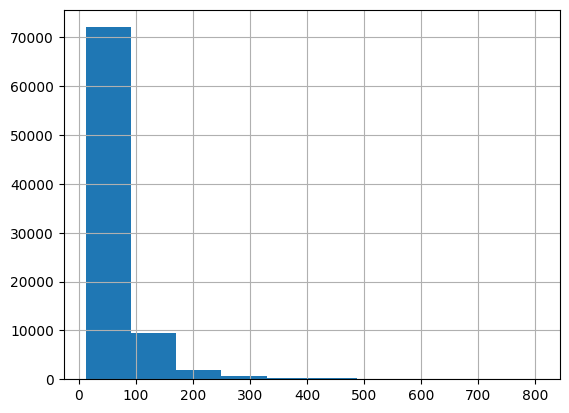

In [3]:
messages["text"] = messages.text.astype(str)
messages["formatted"] = (
    messages["from"].str.cat(messages["text"], sep=":\n").astype(str)
)

truncate_to = 800

messages["truncated"] = False
messages.loc[messages["formatted"].str.len() > truncate_to, "truncated"] = True
messages.loc[messages["formatted"].str.len() > truncate_to, "formatted"] = (
    messages["formatted"].str[:truncate_to] + "..."
)

display(messages["formatted"].str.len().hist())
display(messages["truncated"].value_counts())


Max history entries for Alex: 26
Max history entries for David: 26
Max history entries for Fam: 28
Max history entries for Karla: 34


<AxesSubplot: >

[{'chat_history': 'Kyle Corbitt:\n'
                  'hey everybody woke up pretty sick at home including karla, '
                  'so I probably will be mostly out today just keeping the '
                  'house together\n'
                  '\n'
                  'Kyle Corbitt:\n'
                  '(I actually feel fine, for now at least, but have a lot to '
                  'cover for)\n'
                  '\n'
                  'Kyle Corbitt:\n'
                  'can still get on at 9:15 for sync though in case we have '
                  'things to align\n'
                  '\n'
                  'Alex Chung:\n'
                  'I’ll check the board now\n'
                  '\n'
                  'Alex Chung:\n'
                  'I cleared a few tickets already\n'
                  '\n'
                  'Alex Chung:\n'
                  'I’ll aim to a draft investor letter over the weekend\n'
                  '\n'
                  'Alex Chung:\n'
                  '

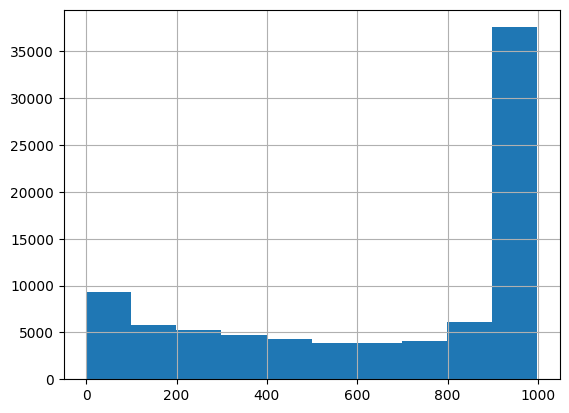

In [4]:
import pprint

messages["chat_history_complete"] = False
messages["chat_history"] = ""

# Populate the `chat_history` column with the previous messages in the conversation

for name, group in messages.groupby("chat_name"):
    group = group.sort_values("date")

    i = 0
    while not group["chat_history_complete"].all() and i < 100:
        i += 1
        history_i = group.shift(i)

        augmented_history = history_i["formatted"] + "\n\n" + group["chat_history"]

        # Messages more than 6 hours apart are probably not part of the same conversation
        too_old = (group["date"] - history_i["date"]) > pd.Timedelta("6 hours")

        # Don't add a message to the history if it would cause the history to be over 1000 characters
        too_long = augmented_history.str.len() > 1000

        # Mark the history as complete if adding another message would break one of the former conditions
        group["chat_history_complete"] = (
            group.chat_history_complete | too_old | too_long | history_i["date"].isna()
        )

        group.loc[~group["chat_history_complete"], "chat_history"] = augmented_history

    # Save the group back to the messages dataframe
    messages.loc[group.index] = group
    print(f"Max history entries for {name}: {i}")

messages["chat_history"] = messages["chat_history"].str[:-2]

display(messages["chat_history"].str.len().hist())
pprint.pprint(messages[messages.chat_name == "Alex"].sample(1).to_dict("records"))

del messages["chat_history_complete"]


In [5]:
# Remove messages that don't have any history or that are truncated

ds_df = messages[(messages.chat_history.str.len() > 0) & ~messages.truncated].copy()

display(ds_df.shape)
ds_df.sample(3)


(80507, 7)

date                from  \
8808  2019-01-30 21:20:23        Kyle Corbitt   
87424 2021-02-18 21:44:39       Karen Corbitt   
83202 2019-11-09 14:33:47  Jacqueline Corbitt   

                                                    text chat_name  \
8808                                                   😢     Karla   
87424                                    She will be 92.       Fam   
83202  If you guys are up for that it's probably the ...       Fam   

                                               formatted  truncated  \
8808                                    Kyle Corbitt:\n😢      False   
87424                    Karen Corbitt:\nShe will be 92.      False   
83202  Jacqueline Corbitt:\nIf you guys are up for th...      False   

                                            chat_history  
8808   Karla Inostroza:\nRough night again\n\nKarla I...  
87424  David Corbitt:\nWe got unicorn cake\n\nChristi...  
83202  Christina Corbitt:\nScott where are you regist...

In [6]:
def format_prompt(row):
    return f"""Respond to chat as {row["from"]}:

Recent messages:

{row["chat_history"]}

{row["from"]}:
"""


ds_df["prompt"] = ds_df.apply(format_prompt, axis=1)

ds_df.prompt.str.len().describe()

print(ds_df[ds_df.chat_name == "Alex"].iloc[1950].prompt)


Respond to chat as Alex Chung:

Recent messages:

Alex Chung:
There’s a heat wave in the Bay Area today. Ill be on mobile for my morning dog walk as I’ll be joining our sync first 30 min

Kyle Corbitt:
to check my understanding, you'll still be on at 7:30 but you'll be on a walk?

Alex Chung:
Yeah

Alex Chung:



In [7]:
# Let's just train on messages sent by Kyle for now
ds_df = ds_df[ds_df["from"] == "Kyle Corbitt"]

ds_df.shape


(31338, 8)

In [8]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

model_id = "google/flan-t5-base"

# Load tokenizer of FLAN-t5-base
tokenizer = AutoTokenizer.from_pretrained(model_id)

prompt_lengths = ds_df.prompt.apply(tokenizer.encode).map(len)
display(prompt_lengths.describe())
max_prompt_length = prompt_lengths.max()

label_lengths = ds_df.text.apply(tokenizer.encode).map(len)
display(label_lengths.describe())
max_label_length = label_lengths.max()


Token indices sequence length is longer than the specified maximum sequence length for this model (521 > 512). Running this sequence through the model will result in indexing errors


count    31338.000000
mean       234.148829
std        104.826550
min         25.000000
25%        146.000000
50%        267.000000
75%        314.000000
max        731.000000
Name: prompt, dtype: float64

count    31338.000000
mean        12.489182
std         15.981490
min          2.000000
25%          5.000000
50%          8.000000
75%         15.000000
max        522.000000
Name: text, dtype: float64

In [9]:
# Let's just drop the longest prompts and completions for now. There aren't that many anyway.

ds_df = ds_df[label_lengths <= 100]
max_target_length = 100

ds_df = ds_df[prompt_lengths <= 512]
max_prompt_length = 512


/tmp/ipykernel_3551474/1048623221.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ds_df = ds_df[prompt_lengths <= 512]


In [10]:
import datasets

train_frac = 0.98

# Take the first train_frac of the df for training and the rest for test.
# Split by date so the model can't cheat on the test set (can still cheat
# on the training set I guess).

ds_df = ds_df.sort_values('date').reset_index(drop=True)[["prompt", "text"]]

train_ds = datasets.Dataset.from_pandas(ds_df.iloc[: int(len(ds_df) * train_frac)], preserve_index=False)
test_ds = datasets.Dataset.from_pandas(ds_df.iloc[int(len(ds_df) * train_frac) :], preserve_index=False)

ds = datasets.DatasetDict({"train": train_ds, "test": test_ds})

ds


DatasetDict({
    train: Dataset({
        features: ['prompt', 'text'],
        num_rows: 30518
    })
    test: Dataset({
        features: ['prompt', 'text'],
        num_rows: 623
    })
})

In [11]:
def preprocess(sample):
    inputs = tokenizer(
        sample["prompt"],
        max_length=max_prompt_length,
        padding="max_length",
        truncation=True,
    )

    labels = tokenizer(
        sample["text"],
        max_length=max_target_length,
        padding="max_length",
        truncation=True,
    )

    # Replace padding token with -100 so that loss in padding is ignored. TODO: might be
    # possible to do this automatically in the tokenizer config?
    input_tokens = [
        [(-100 if token == tokenizer.pad_token_id else token) for token in label]
        for label in labels["input_ids"]
    ]

    inputs["labels"] = input_tokens

    return inputs


tokenized_ds = ds.map(preprocess, batched=True, batch_size=1000)
tokenized_ds


  0%|          | 0/31 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['prompt', 'text', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 30518
    })
    test: Dataset({
        features: ['prompt', 'text', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 623
    })
})

In [12]:
tokenized_ds.save_to_disk("data/chat_history")

Saving the dataset (0/1 shards):   0%|          | 0/30518 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/623 [00:00<?, ? examples/s]